In [ ]:
import pandas as pd
import re
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix


# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.overall_cleaned_base_and_pr_ef_policyef;'
df = pd.read_sql(query, con=engine)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

df_filtered = df[df['Policy Status'].isin(['Renewed', 'Not Renewed'])]

df_filtered['Status_Binary'] = df_filtered['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

# Select relevant columns
selected_columns = ['renewal type', 'product name', 'product name 2',  'biztype', 'age', 'vehicle idv', 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 
 'total premium payable', 'ncb % previous year', 'applicable discount with ncb', 'tie up',
 'Number of claims', 'approved', 'denied', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status', 'withdrawn', 'policy_wise_purchase', 'Status_Binary']

df_selected = df_filtered[selected_columns]

# Convert numerical columns to float
numerical_columns = ['age', 'vehicle idv', 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 
 'total premium payable', 'ncb % previous year', 'applicable discount with ncb',
 'Number of claims', 'approved', 'denied', 'Policy Tenure', 'Customer Tenure', 'withdrawn', 'policy_wise_purchase', 'Status_Binary']


df_selected[numerical_columns] = df_selected[numerical_columns].apply(pd.to_numeric, errors='coerce')

# One-hot encode categorical columns
categorical_columns = ['renewal type', 'product name', 'product name 2',  'biztype', 'tie up', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status']

df_selected = pd.get_dummies(df_selected, columns=categorical_columns, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_selected = pd.DataFrame(imputer.fit_transform(df_selected), columns=df_selected.columns)

# Convert to sparse matrix
X = csr_matrix(df_selected.drop(columns=['Status_Binary']).values)
y = df_selected['Status_Binary']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3780\3725740938.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Status_Binary'] = df_filtered['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_3780\3725740938.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[numerical_columns] = df_selected[numerical_columns].apply(pd.to_numeric, errors='coerce')


Shape of X: (1503014, 47)
Shape of y: (1503014,)


In [ ]:
import numpy as np
import json
from collections import defaultdict
from catboost import CatBoostClassifier

# Prepare feature names from your DataFrame (excluding target 'Status_Binary')
feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

# Train CatBoost model
cat_model = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

cat_model.fit(X, y)

# Save the model in JSON format
model_file = "catboost_model.json"
cat_model.save_model(model_file, format="json")

# Load the JSON model
with open(model_file, "r") as file:
    model_data = json.load(file)

# Create dictionaries to count condition occurrences for each class
condition_counts = {0: defaultdict(int), 1: defaultdict(int)}

# Process each tree from the JSON model
for tree in model_data["oblivious_trees"]:
    splits = tree["splits"]       
    num_splits = len(splits)      
    num_leaves = len(tree["leaf_values"])
    
    # For each leaf, reconstruct its decision path and count conditions
    for leaf_index in range(num_leaves):
        path_bin = format(leaf_index, f"0{num_splits}b")
        conditions = []
        for j, bit in enumerate(path_bin):
            feature_index = splits[j]["float_feature_index"]
            threshold = splits[j]["border"]
            feature_name = feature_names[feature_index]
            if bit == '0':
                condition = f"{feature_name} < {threshold}"
            else:
                condition = f"{feature_name} >= {threshold}"
            conditions.append(condition)
        
        # Determine the predicted class for this leaf using sigmoid
        logit = float(tree["leaf_values"][leaf_index])
        probability = 1 / (1 + np.exp(-logit))
        predicted_class = 1 if probability > 0.5 else 0
        
        # Increase count for each unique condition in the path
        for cond in set(conditions):
            condition_counts[predicted_class][cond] += 1

# Filter and output the main conditions 
top_n = 30
main_reasons = {}
for cls in (0, 1):
    sorted_conditions = sorted(condition_counts[cls].items(), key=lambda x: x[1], reverse=True)
    main_reasons[cls] = sorted_conditions[:top_n]

output_file = "main_decision_reasons.txt"
with open(output_file, "w") as file:
    for cls in (0, 1):
        file.write(f"Main Conditions for Class {cls}:\n")
        file.write("=" * 40 + "\n")
        for condition, count in main_reasons[cls]:
            file.write(f"{condition}  (Count: {count})\n")
        file.write("\n")

print(f"Main decision reasons saved to '{output_file}'")

Main decision reasons saved to 'main_decision_reasons.txt'



Training Random Forest Model - Single Run

Random Forest - Tree 0 Rules:
|--- ncb % previous year <= 10.00
|   |--- tie up_MARUTI <= 0.50
|   |   |--- total od premium <= 6013.50
|   |   |   |--- tie up_HYUNDAI <= 0.50
|   |   |   |   |--- product name_Private Car Policy - Bundled Cover <= 0.50
|   |   |   |   |   |--- biztype_Renewal Business <= 0.50
|   |   |   |   |   |   |--- applicable discount with ncb <= 62.50
|   |   |   |   |   |   |   |--- Renewal Rate Status_Null <= 0.50
|   |   |   |   |   |   |   |   |--- gst <= 1078.50
|   |   |   |   |   |   |   |   |   |--- before gst add-on gwp <= 498.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- before gst add-on gwp >  498.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- gst >  1078.50
|   |   |   |   |   |   |   |   |   |--- renewal type_TY Onwards <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |

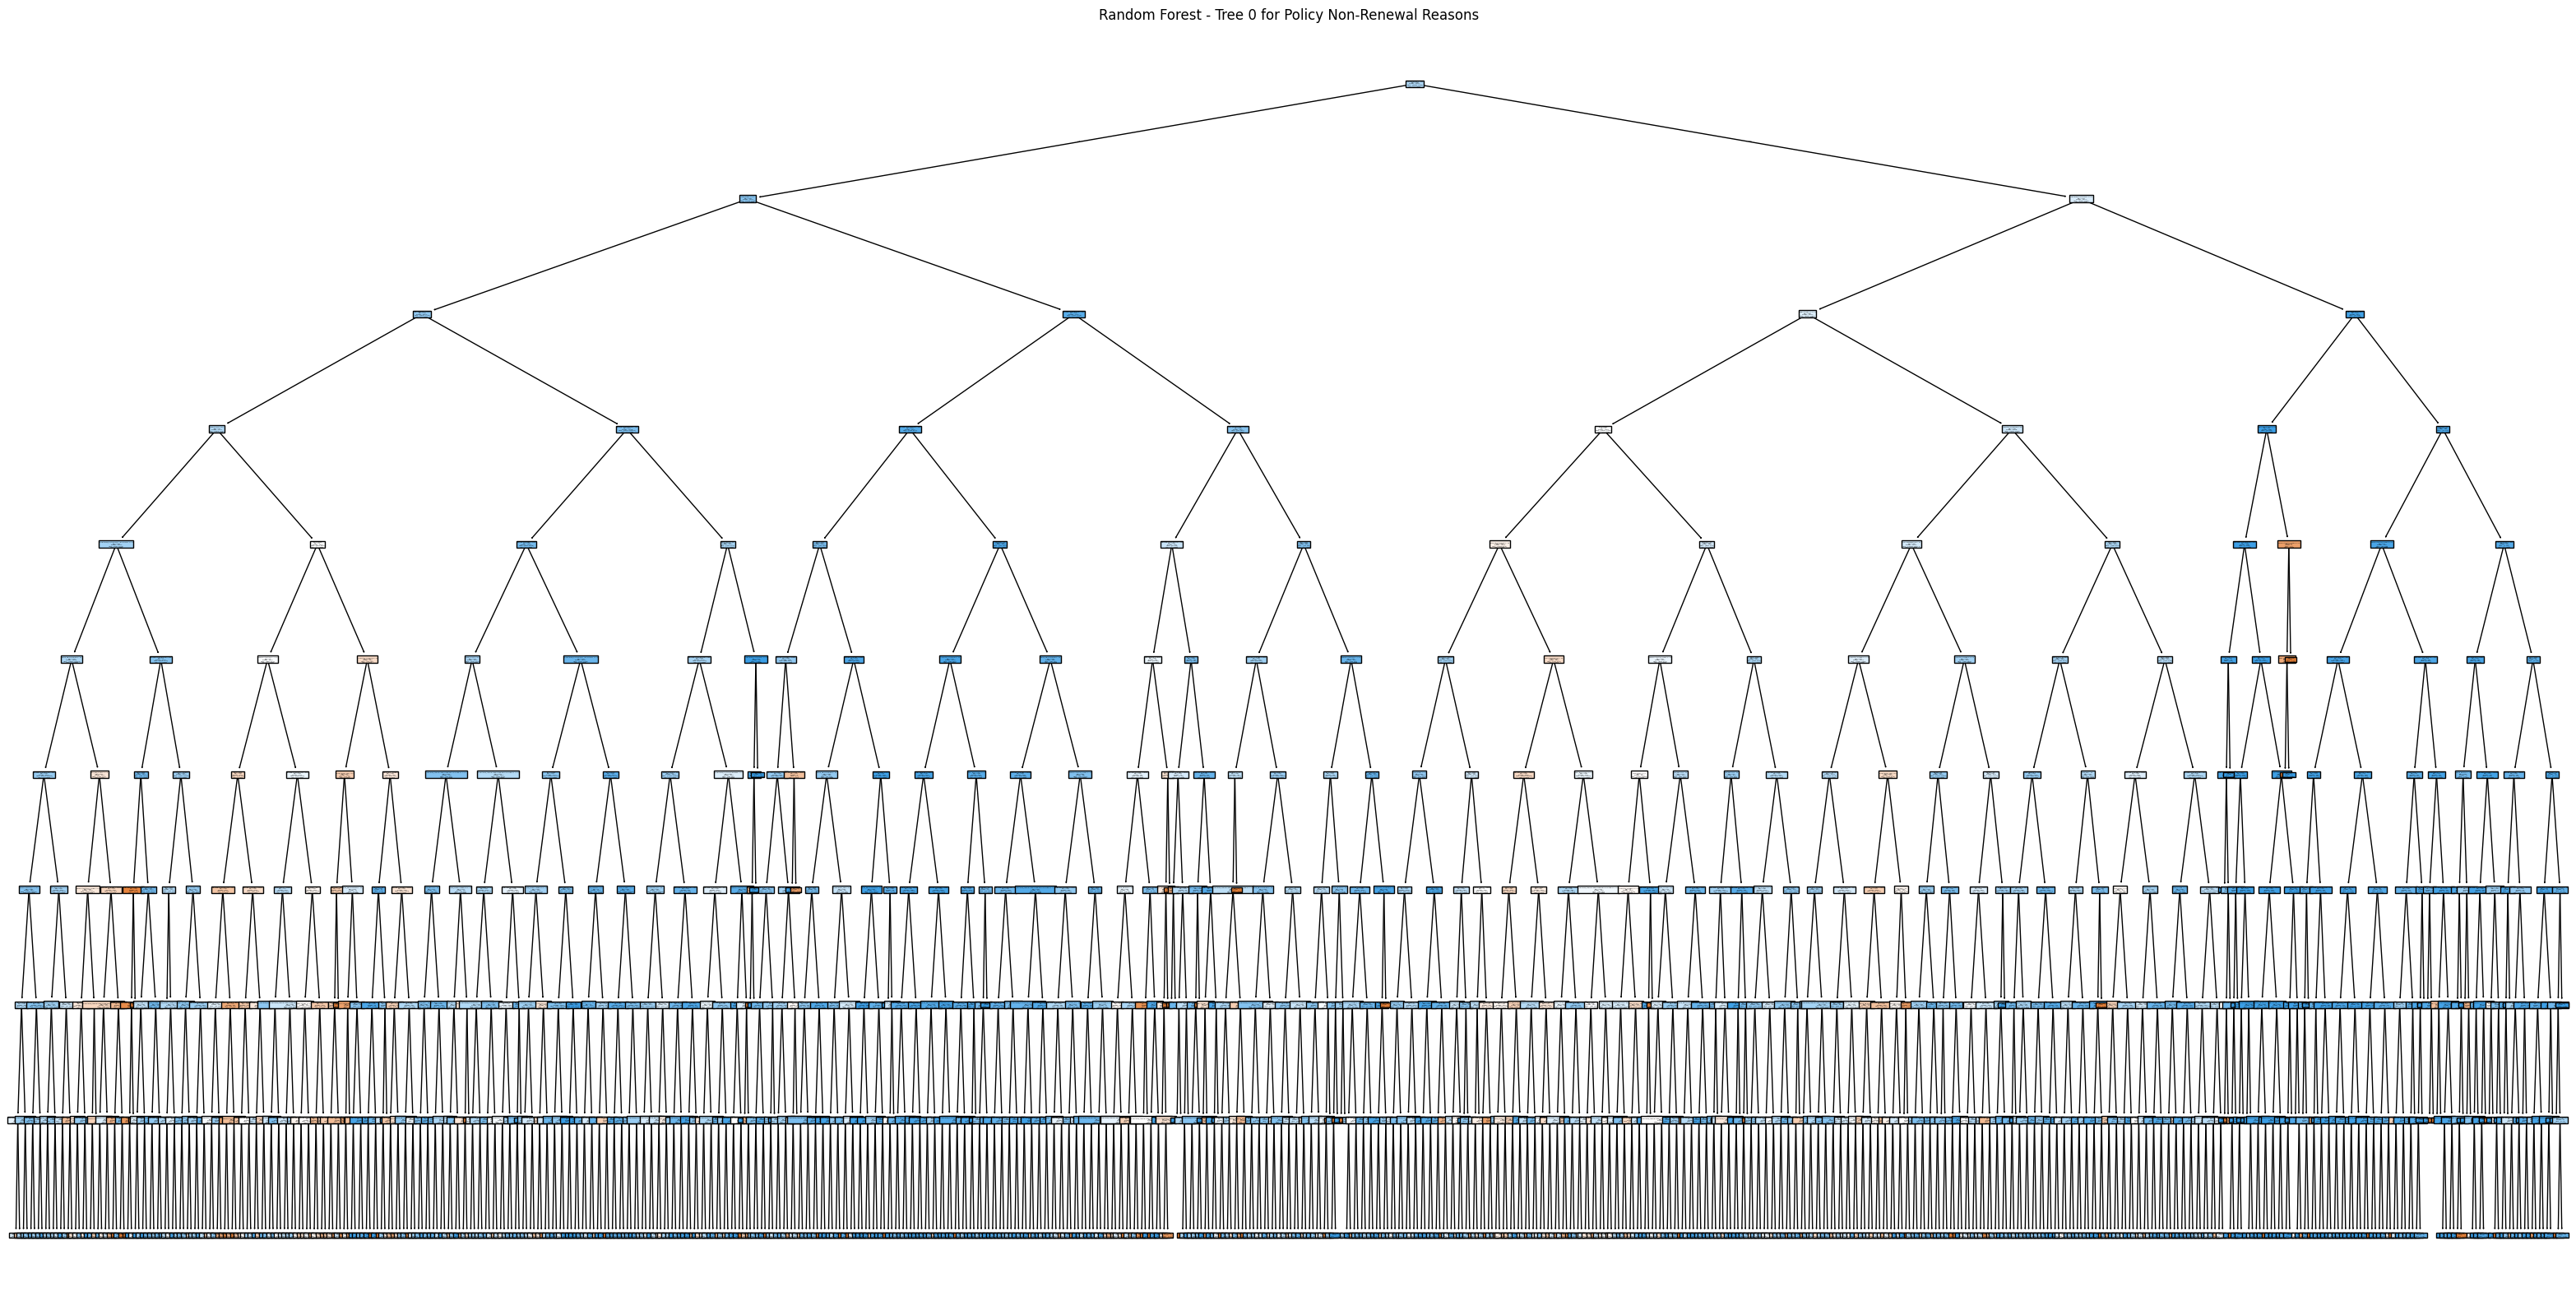


Random Forest tree rules saved to 'random_forest_tree_rules.txt'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree

# Prepare feature names
feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

# Train Random Forest model
print("\nTraining Random Forest Model - Single Run")
model_1 = RandomForestClassifier(random_state=42, max_depth=10)
model_1.fit(X, y)

# Export tree rules for the first tree in the forest
first_tree = model_1.estimators_[0]
tree_rules_rf = export_text(first_tree, feature_names=feature_names)
print("\nRandom Forest - Tree 0 Rules:")
print(tree_rules_rf)

# Plot the first tree of the random forest
plt.figure(figsize=(40, 20))
plot_tree(first_tree, 
          feature_names=feature_names, 
          class_names=['Renewed', 'Not Renewed'], 
          filled=True)
plt.title('Random Forest - Tree 0 for Policy Non-Renewal Reasons')
plt.savefig("random_forest_tree_0.png", dpi=300)
plt.show()

with open("random_forest_tree_rules.txt", "w") as file:
    file.write(tree_rules_rf)

print("\nRandom Forest tree rules saved to 'random_forest_tree_rules.txt'")